In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
import random

2023-12-25 10:17:20.109220: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-25 10:17:20.134050: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-25 10:17:20.134073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-25 10:17:20.134700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-25 10:17:20.138907: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%load_ext autoreload
%autoreload 2
from base import utils, datahandler, prediction_models, evaluation

In [3]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

In [4]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

In [5]:
# get all labels in the dataframes
keys_list = list(split_dataframes.keys())
random.Random(69).shuffle(keys_list) # shuffle, but with a seed for reproducability
split_idx = int(len(keys_list) * 0.8)
train_keys = keys_list[:split_idx]
train_labels_EW = []
train_labels_NS = []
val_keys = keys_list[split_idx:]
val_labels_EW = []
val_labels_NS = []
for key in train_keys:
    train_labels_EW += list(split_dataframes[key]['EW'].unique())
    train_labels_NS += list(split_dataframes[key]['NS'].unique())
for key in val_keys:
    val_labels_EW += list(split_dataframes[key]['EW'].unique())
    val_labels_NS += list(split_dataframes[key]['NS'].unique())
train_labels_EW = list(dict.fromkeys(train_labels_EW))
train_labels_NS = list(dict.fromkeys(train_labels_NS))
val_labels_EW = list(dict.fromkeys(val_labels_EW))
val_labels_NS = list(dict.fromkeys(val_labels_NS))
print(train_labels_EW)
print(val_labels_EW)
print(train_labels_NS)
print(val_labels_NS)


['SS-CK', 'SS-NK', 'AD-NK', 'IK-CK', 'SS-HK', 'ID-NK', 'SS-EK', 'IK-HK', 'IK-EK']
['SS-HK', 'ID-NK', 'SS-CK', 'SS-NK', 'AD-NK', 'IK-CK', 'IK-HK', 'SS-EK']
['SS-CK', 'SS-NK', 'IK-CK', 'SS-HK', 'ID-NK', 'IK-EK', 'IK-HK', 'SS-EK']
['SS-HK', 'ID-NK', 'SS-CK', 'SS-NK', 'IK-CK', 'IK-HK', 'SS-EK']


In [18]:
some_dataframes = {}
for df_k in list(split_dataframes.keys())[:3]:
    some_dataframes[df_k] = split_dataframes[df_k]

In [21]:
ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=input_features,
                                      train_val_split=0.85, stride=1,
                                      input_history_steps=8, input_future_steps=8, seed=69)

Creating dataset from 2 train and 1 val objects
Creating datasets with labels ['EW', 'EW_Node', 'EW_Type', 'NS', 'NS_Node', 'NS_Type']
Created datasets with seed 69


In [22]:
train_combined, val_combined = ds_gen.get_datasets(512, label_features=['EW', 'NS'], shuffle=True)
print(train_combined.element_spec)


(TensorSpec(shape=(None, 18, 15), dtype=tf.float64, name=None), {'EW': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'NS': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})


2023-12-25 10:21:50.357106: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8, 15)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 8, 128)               5888      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 8, 128)               512       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 8, 128)               0         ['batch_normalization[0][0

2023-12-25 10:21:54.957995: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-25 10:21:55.051995: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-25 10:21:55.739563: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff19e350ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-25 10:21:55.739587: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-12-25 10:21:55.745385: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703528515.810316   17954 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


903/903 [==============================] - ETA: 0s - loss: 0.8116 - EW_loss: 0.3148 - NS_loss: 0.4284 - EW_accuracy: 0.8973 - NS_accuracy: 0.8581
Epoch 1: loss improved from inf to 0.81162, saving model to best_model.hdf5
903/903 [==============================] - 11s 6ms/step - loss: 0.8116 - EW_loss: 0.3148 - NS_loss: 0.4284 - EW_accuracy: 0.8973 - NS_accuracy: 0.8581 - val_loss: 1.6456 - val_EW_loss: 0.6336 - val_NS_loss: 0.9565 - val_EW_accuracy: 0.8714 - val_NS_accuracy: 0.8266
Epoch 2/50
893/903 [============================>.] - ETA: 0s - loss: 0.4415 - EW_loss: 0.1552 - NS_loss: 0.2365 - EW_accuracy: 0.9479 - NS_accuracy: 0.9161
Epoch 2: loss improved from 0.81162 to 0.44099, saving model to best_model.hdf5
903/903 [==============================] - 8s 5ms/step - loss: 0.4410 - EW_loss: 0.1549 - NS_loss: 0.2362 - EW_accuracy: 0.9480 - NS_accuracy: 0.9163 - val_loss: 1.8975 - val_EW_loss: 0.7238 - val_NS_loss: 1.1274 - val_EW_accuracy: 0.8660 - val_NS_accuracy: 0.8273
Epoch 3/50

/home/user/Code/splid-challenge/base/prediction_models.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


903/903 [==============================] - 5s 2ms/step - loss: 0.1414 - EW_loss: 0.0447 - NS_loss: 0.0846 - EW_accuracy: 0.9824 - NS_accuracy: 0.9649


[0.14139613509178162,
 0.04470283165574074,
 0.08456556499004364,
 0.9824156761169434,
 0.9649309515953064]

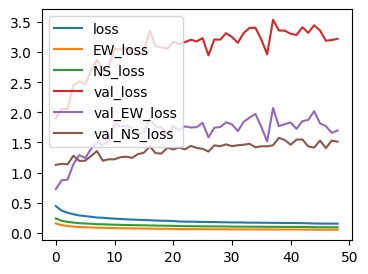

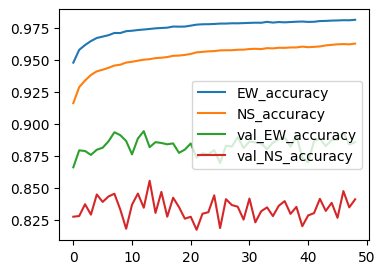

In [7]:
dense_combined_model = prediction_models.CNN(train_combined, conv_layers=[128,128,128], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
dense_combined_model.summary()
hist = dense_combined_model.fit(train_combined, val_ds=val_combined, target_metric='loss', epochs=50, verbose=1, plot_hist=False, save_best_only=True)
dense_combined_model.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
dense_combined_model.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])
dense_combined_model.evaluate(train_combined)

In [ ]:
# TODO: find out if we can directly train for precision/challenge metrics
# TODO: maybe it makes sense to look at values before and after the node? Given that we are trying to detect changes...
# TODO: check if train_NS even contains all the labels in val_NS... in general, train should contain all labels
# TODO: Make sure labelencoder gets saved
# TODO: some of the features cross sign boundaries -> feature engineering necessary!

In [8]:
def prepare_submission_df(ds, model, model_output_features, label_decoders):
    '''Prepare dataframes for submission based on models predictions. The output_labels need to be in the same order as they were when creating the dataset!'''
    assert(len(model_output_features) == len(label_decoders))
    inputs = np.concatenate([element for element in ds.map(lambda x,y,z: x).as_numpy_iterator()])
    identifiers = np.concatenate([element for element in ds.map(lambda x,y,z: z).as_numpy_iterator()])
    
    df = pd.DataFrame(np.concatenate([identifiers.reshape(-1,2)], axis=1), columns=['ObjectID', 'TimeIndex'], dtype=np.int32)

    preds = model.predict(inputs)
    for ft_idx, feature in enumerate(model_output_features):
        labels = np.concatenate([element[feature] for element in ds.map(lambda x,y,z: y).as_numpy_iterator()])
        labels_decoded = label_decoders[ft_idx].inverse_transform(labels)
        preds_argmax = np.argmax(preds[ft_idx], axis=1) if len(model_output_features)>1 else np.argmax(preds, axis=1)
        preds_decoded = label_decoders[ft_idx].inverse_transform(preds_argmax)
        df[f'{feature}'] = labels_decoded
        df[f'Predicted_{feature}'] = preds_decoded
    return df


In [9]:
ground_truth = pd.read_csv(challenge_data_dir / 'train_labels.csv')
ground_truth_train = ground_truth[ground_truth['ObjectID'].isin(map(int, ds_gen.train_keys))].copy()
ground_truth_val = ground_truth[ground_truth['ObjectID'].isin(map(int, ds_gen.val_keys))].copy()

In [10]:
train_EW, val_EW = ds_gen.get_datasets(128, label_features=['EW', 'NS'], shuffle=False, keep_identifier=True)
df_train=prepare_submission_df(ds=train_EW, model=dense_combined_model.model, model_output_features=['EW', 'NS'], label_decoders=[ds_gen.combined_label_encoder, ds_gen.combined_label_encoder])
smoothed_df_train = utils.smooth_predictions(df_train, past_steps=3, fut_steps=10)
train_results = utils.convert_classifier_output(smoothed_df_train).sort_values(['ObjectID']).reset_index(drop=True)
print(len(train_results))
# print(train_results.sort_values(['ObjectID', 'TimeIndex', 'Direction']).head(50))
print(len(ground_truth_train))
# print(ground_truth_train.sort_values(['ObjectID', 'TimeIndex', 'Direction']).head(50))
evaluator = evaluation.NodeDetectionEvaluator(ground_truth_train, train_results)
precision, recall, f2, rmse = evaluator.score()
print(f'Precision for the train set: {precision:.2f}')
print(f'Recall for the train set: {recall:.2f}')
print(f'F2 for the train set: {f2:.2f}')
print(f'RMSE for the train set: {rmse:.2f}')

# TODO: predict on val with simly ss node and predict engine type... might give quite high precision?
# Dense result: F2 0.49/0.32 (t/v)
# Conv result: F2 0.53/0.37

14440/14440 [==============================] - 13s 889us/step


Smoothing: 100%|██████████| 212/212 [01:24<00:00,  2.50it/s]


1566
956
Precision for the train set: 0.36
Recall for the train set: 0.61
F2 for the train set: 0.53
RMSE for the train set: 1.76


In [11]:
train_EW, val_EW = ds_gen.get_datasets(128, label_features=['EW', 'NS'], shuffle=False, keep_identifier=True)
df_val=prepare_submission_df(ds=val_EW, model=dense_combined_model.model, model_output_features=['EW', 'NS'], label_decoders=[ds_gen.combined_label_encoder, ds_gen.combined_label_encoder])
smoothed_df_val = utils.smooth_predictions(df_val, past_steps=3, fut_steps=10)
val_results = utils.convert_classifier_output(smoothed_df_val).sort_values(['ObjectID']).reset_index(drop=True)
evaluator = evaluation.NodeDetectionEvaluator(ground_truth_val, val_results)
precision, recall, f2, rmse = evaluator.score()
print(f'Precision for the val set: {precision:.2f}')
print(f'Recall for the val set: {recall:.2f}')
print(f'F2 for the val set: {f2:.2f}')
print(f'RMSE for the val set: {rmse:.2f}')


2588/2588 [==============================] - 3s 987us/step


Smoothing: 100%|██████████| 38/38 [00:13<00:00,  2.77it/s]


Precision for the val set: 0.15
Recall for the val set: 0.60
F2 for the val set: 0.37
RMSE for the val set: 1.93


In [288]:
train_EW, val_EW = ds_gen.get_datasets(128, label_features=['EW'], shuffle=False, keep_identifier=True)
train_NS, val_NS = ds_gen.get_datasets(128, label_features=['NS'], shuffle=False, keep_identifier=True)
df_EW = prepare_submission_df(ds=train_EW, model=dense_model_ew.model, model_output_features=['EW'], label_decoders=[ds_gen.combined_label_encoder])
df_NS = prepare_submission_df(ds=train_NS, model=dense_model_ns.model, model_output_features=['NS'], label_decoders=[ds_gen.combined_label_encoder])
combined_df = df_EW
combined_df['NS'] = df_NS['NS']
combined_df['Predicted_NS'] = df_NS['Predicted_NS']
smoothed_df_val = utils.smooth_predictions(combined_df)
train_results = utils.convert_classifier_output(smoothed_df_val).sort_values(['ObjectID']).reset_index(drop=True)
evaluator = evaluation.NodeDetectionEvaluator(ground_truth_train, train_results)
precision, recall, f2, rmse = evaluator.score()
print(f'Precision for the train set: {precision:.2f}')
print(f'Recall for the train set: {recall:.2f}')
print(f'F2 for the train set: {f2:.2f}')
print(f'RMSE for the train set: {rmse:.2f}')

1019/1019 [==============================] - 2s 2ms/step


Smoothing: 100%|██████████| 15/15 [00:16<00:00,  1.12s/it]


Precision for the train set: 0.65
Recall for the train set: 0.65
F2 for the train set: 0.65
RMSE for the train set: 0.58
